<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# LightFM -  hybrid matrix factorisation (Python, CPU)

In [156]:
import sys
sys.path.append("../../")
import os

import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

import lightfm
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm import cross_validation

# Import LightFM's evaluation metrics
from lightfm.evaluation import precision_at_k as lightfm_prec_at_k
from lightfm.evaluation import recall_at_k as lightfm_recall_at_k

# Import repo's evaluation metrics
from reco_utils.evaluation.python_evaluation import (
    precision_at_k, recall_at_k)

from reco_utils.common.timer import Timer
from reco_utils.dataset import movielens
from reco_utils.recommender.lightfm.lightfm_utils import (
    track_model_metrics, prepare_test_df, prepare_all_predictions,
    compare_metric, similar_users, similar_items)

print("System version: {}".format(sys.version))
print("LightFM version: {}".format(lightfm.__version__))

System version: 3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]
LightFM version: 1.15


### Defining variables

In [157]:
# default number of recommendations
K = 20
# percentage of data used for testing
TEST_PERCENTAGE = 0.2
# model learning rate
LEARNING_RATE = 0.005
# no of latent factors
NO_COMPONENTS = 20
# no of epochs to fit model
NO_EPOCHS = 20
# no of threads to fit model
NO_THREADS = 8
# regularisation for both user and item features
ITEM_ALPHA=1e-6
USER_ALPHA=1e-6

# seed for pseudonumber generations
SEEDNO = 42

###  Retrieve data

In [158]:
def func(x):
    return random.randint(1,5)
def func1(x,y):
    return str(x)+'|'+str(y)
def func2(x,y):
    return str(x)+'|'+str(y)

In [159]:
# data = pd.read_csv("../../Post dataset/views.csv")
# data = data.merge(pd.read_csv("../../Post dataset/posts.csv"), on='itemID')
# data = data.merge(pd.read_csv("../../Post dataset/users.csv"), on='userID')
# data['rating'] = 0
# data['rating'] = data.apply(lambda x: func(x['rating']),axis=1)
# data['item_features'] = data.apply(lambda x: func1(x['post_type'],x['category']),axis=1)
# data['user_features'] = data.apply(lambda x: func2(x['gender'],x['academics']),axis=1)
# data.drop(columns=['timestamp','name','title','post_type','category','gender','academics'],inplace=True)
# data = data[['userID','itemID','rating','item_features','user_features']]
# data.to_csv('../../Post dataset/data.csv',index=False)

data = pd.read_csv('../../Post dataset/data.csv')
data.head()

,userID,itemID,rating,item_features,user_features
0,5df49b32cc709107827fb3c7,5ec821ddec493f4a2655889e,4,artwork|Visual Arts|Graphic Design|Artistic de...,female|undergraduate
1,5df49b32cc709107827fb3c7,5ec1fd0974f7660d73aa0fd5,1,artwork|Drawings,female|undergraduate
2,5df49b32cc709107827fb3c7,5ecd5d417023451e662235c5,4,blog|Computer Technology|Machine Learning,female|undergraduate
3,5df49b32cc709107827fb3c7,5ecb72c0eaff6b0c3a58a48e,2,artwork|Photography|Architecture|Visual Arts|G...,female|undergraduate
4,5df49b32cc709107827fb3c7,5ea5aacd10426255a7aa9b71,3,project|nan,female|undergraduate


### Prepare data

In [160]:
dataset = Dataset()

In [161]:
dataset.fit(users=data['userID'], 
            items=data['itemID'])

# quick check to determine the number of unique users and items in the data
num_users, num_topics = dataset.interactions_shape()
print(f'Num users: {num_users}, num_topics: {num_topics}.')

Num users: 118, num_topics: 493.


In [162]:
(interactions, weights) = dataset.build_interactions(data.iloc[:, 0:2].values)
print(repr(interactions))

<118x493 sparse matrix of type '<class 'numpy.int32'>'
	with 1447 stored elements in COOrdinate format>


In [163]:
train_interactions, test_interactions = cross_validation.random_train_test_split(
    interactions, test_percentage=TEST_PERCENTAGE,
    random_state=np.random.RandomState(SEEDNO))

In [164]:
print(f"Shape of train interactions: {train_interactions.shape}")
print(f"Shape of test interactions: {test_interactions.shape}")

Shape of train interactions: (118, 493)
Shape of test interactions: (118, 493)


### Fit the LightFM model

In [165]:
model1 = LightFM(loss='warp', no_components=NO_COMPONENTS, 
                 learning_rate=LEARNING_RATE,                 
                 random_state=np.random.RandomState(SEEDNO))

In [166]:
model1.fit(interactions=train_interactions,
          epochs=NO_EPOCHS);

### Prepare model evaluation data

In [167]:
uids, iids, interaction_data = cross_validation._shuffle(
    interactions.row, interactions.col, interactions.data, 
    random_state=np.random.RandomState(SEEDNO))

cutoff = int((1.0 - TEST_PERCENTAGE) * len(uids))
test_idx = slice(cutoff, None)

In [168]:
uid_map, ufeature_map, iid_map, ifeature_map = dataset.mapping()

In [169]:
with Timer() as test_time:
    test_df = prepare_test_df(test_idx, uids, iids, uid_map, iid_map, weights)
print(f"Took {test_time.interval:.1f} seconds for prepare and predict test data.")  
time_reco1 = test_time.interval

Took 0.0 seconds for prepare and predict test data.


In [170]:
test_df.sample(5)

,userID,itemID,rating
74,5e99b0d4a3258347b42f2bf0,5e99b786a3258347b42f2bfd,1.0
267,5d6d2bb87fa40e1417a49315,5ebc3239514aab59896bcc86,1.0
242,5ebc2ec4514aab59896bcc84,5e95f44ba3258347b42f2a31,1.0
200,5deeef6142a8854bf6eabab9,5ed09ad076027d35905cc15f,1.0
129,5e93471ea3258347b42f279f,5e91a2dda3258347b42f276d,1.0


In addition, the predictions of all unseen user-item pairs (e.g. removing those seen in the training data) can be prepared as follows:

In [171]:
with Timer() as test_time:
    all_predictions = prepare_all_predictions(data, uid_map, iid_map, 
                                              interactions=train_interactions,
                                              model=model1, 
                                              num_threads=NO_THREADS)
print(f"Took {test_time.interval:.1f} seconds for prepare and predict all data.")
time_reco2 = test_time.interval

Took 21.0 seconds for prepare and predict all data.


In [172]:
all_predictions.sample(5)

,userID,itemID,prediction
38119,5e26bb482a37d20505da2c10,5e866cffa3258347b42f24ef,-0.142070
18582,5ed2672576027d35905cc7f6,5ea323a010426255a7aa9aca,-0.060050
5529,5ed0defa76027d35905cc2de,5e733f1c1b24db0468e90cf1,-0.047782
56098,5e5855ced701ab08af792b51,5ecc186aeaff6b0c3a58a53f,0.076154
10685,5ed0dfec76027d35905cc2ec,5ebd5b46514aab59896bcd5a,0.025744


### Model evaluation

In [173]:
with Timer() as test_time:
    eval_precision = precision_at_k(rating_true=test_df, 
                                rating_pred=all_predictions, k=K)
    eval_recall = recall_at_k(test_df, all_predictions, k=K)
time_reco3 = test_time.interval

# with Timer() as test_time:
#     eval_precision_lfm = lightfm_prec_at_k(model1, test_interactions, 
#                                            train_interactions, k=K).mean()
#     eval_recall_lfm = lightfm_recall_at_k(model1, test_interactions, 
#                                           train_interactions, k=K).mean()
# time_lfm = test_time.interval
    
print(
    "------ Using Repo's evaluation methods ------",
    f"Precision@K:\t{eval_precision:.6f}",
    f"Recall@K:\t{eval_recall:.6f}",
#     "\n------ Using LightFM evaluation methods ------",
#     f"Precision@K:\t{eval_precision_lfm:.6f}",
#     f"Recall@K:\t{eval_recall_lfm:.6f}", 
    sep='\n')

------ Using Repo's evaluation methods ------
Precision@K:	0.034328
Recall@K:	0.133274


## Recommender with LightFM using explicit feedbacks and additional item and user features

### Extract and prepare item features

In [174]:
# split based on the separator
item_features = [x.split('|') for x in data['item_features']]
# retrieve the all the unique in the data
all_item_features = sorted(list(set(itertools.chain.from_iterable(item_features))))
# quick look at the all the within the data
all_item_features

['2D Composition',
 'Accounting',
 'Accounting Theory And Practices',
 'Acrylics',
 'Advertising',
 'Alternate Dispute Resolution',
 'Animal Biotechnology',
 'Applied Ethics',
 'Archeology',
 'Architecture',
 'Art',
 'Art; Science',
 'Articulation',
 'Artificial Intelligence',
 'Artistic design',
 'Atomic Physics',
 'Audit Evidence',
 'Audit Remark',
 'Auditing',
 'Banking',
 'Banking Companies',
 'Banking Law',
 'Banking Technology',
 'Basics of Communiaction',
 'Bio-entrepreneurship',
 'Biotechnology',
 'Break even Point',
 'Business',
 'Business Enviorment',
 'Business Management',
 'Business Organisation',
 'Business Planning',
 'Business Skills',
 'Business Strategies',
 'Calligraphy',
 'Cardiology',
 'Ceramics',
 'Child Development',
 'Cloud Computing',
 'Colonialism In India',
 'Communication',
 'Company Law',
 'Competition Laws',
 'Computation',
 'Computer Application',
 'Computer Creation',
 'Computer Technology',
 'Conceptual',
 'Corporate Accounting',
 'Corporate Social Resp

#### Extract and prepare user features

In [175]:
# split based on the separator
user_features = [x.split('|') for x in data['user_features']]
# retrieve the all the unique in the data
all_user_features = sorted(list(set(itertools.chain.from_iterable(user_features))))
# quick look at the all the within the data
all_user_features

['female', 'graduate', 'male', 'undefined', 'undergraduate']

### Prepare data and features

In [176]:
dataset2 = Dataset()
dataset2.fit(data['userID'], 
            data['itemID'], 
            item_features=all_item_features,
            user_features=all_user_features)

In [177]:
item_features = dataset2.build_item_features(
    (x, y) for x,y in zip(data.itemID, item_features))
with open('item_features.pickle', 'wb') as file:
    pickle.dump(item_features, file, protocol=pickle.HIGHEST_PROTOCOL)
item_features

<493x732 sparse matrix of type '<class 'numpy.float32'>'
	with 1916 stored elements in Compressed Sparse Row format>

In [178]:
user_features = dataset2.build_user_features(
    (x, y) for x,y in zip(data.userID, user_features))
with open('user_features.pickle', 'wb') as file:
    pickle.dump(user_features, file, protocol=pickle.HIGHEST_PROTOCOL)
user_features

<118x123 sparse matrix of type '<class 'numpy.float32'>'
	with 352 stored elements in Compressed Sparse Row format>

In [179]:
(interactions2, weights2) = dataset2.build_interactions(data.iloc[:, 0:2].values)

train_interactions2, test_interactions2 = cross_validation.random_train_test_split(
    interactions2, test_percentage=TEST_PERCENTAGE,
    random_state=np.random.RandomState(SEEDNO))
with open('train_interactions2.pickle', 'wb') as file:
    pickle.dump(train_interactions2, file, protocol=pickle.HIGHEST_PROTOCOL)
train_interactions2

<118x493 sparse matrix of type '<class 'numpy.int32'>'
	with 1157 stored elements in COOrdinate format>

### Hyperparams Tuning

In [180]:
LEARNING_RATEs = np.linspace(0.5, 0.0001 , num=5)
ALPHAs = np.linspace(1e-5, 1e-7 , num=2)
LEARNING_RATEs = [0.375025]
ALPHAs = [1e-07]
uids, iids, interaction_data = cross_validation._shuffle(
                interactions2.row, interactions2.col, interactions2.data, 
                random_state=np.random.RandomState(SEEDNO))
uid_map, ufeature_map, iid_map, ifeature_map = dataset2.mapping()
test_df2 = prepare_test_df(test_idx, uids, iids, uid_map, iid_map, weights2)

best_precision = 0
for lr in LEARNING_RATEs:
    for a in ALPHAs:
        ia = ua = a
        model2 = LightFM(loss='warp', no_components=NO_COMPONENTS, 
                         learning_rate=lr, 
                         item_alpha=ia,
                         user_alpha=ua,
                         random_state=np.random.RandomState(SEEDNO))

        model2.fit(interactions=train_interactions2,
                   user_features=user_features,
                   item_features=item_features,
                   epochs=NO_EPOCHS);

        all_predictions2 = prepare_all_predictions(data, uid_map, iid_map, 
                                                      interactions=train_interactions2,
                                                       user_features=user_features,
                                                       item_features=item_features,
                                                       model=model2,
                                                       num_threads=NO_THREADS)
        eval_precision2 = precision_at_k(rating_true=test_df2, 
                            rating_pred=all_predictions2, k=K)

        print(f"LR:{lr} ITEM_ALPHA:{ia} USER_ALPHA:{ua} PRECISION:{eval_precision2}")
        if(eval_precision2>best_precision):
            best_precision = eval_precision2
            LEARNING_RATE = lr
            ITEM_ALPHA = ia
            USER_ALPHA = ua

LR:0.375025 ITEM_ALPHA:1e-07 USER_ALPHA:1e-07 PRECISION:0.03432835820895522


### Fit the LightFM model with additional user and item features

In [181]:
model2 = LightFM(loss='warp', no_components=NO_COMPONENTS, 
                 learning_rate=LEARNING_RATE, 
                 item_alpha=ITEM_ALPHA,
                 user_alpha=USER_ALPHA,
                 random_state=np.random.RandomState(SEEDNO))

In [182]:
model2.fit(interactions=train_interactions2,
           user_features=user_features,
           item_features=item_features,
           epochs=NO_EPOCHS);

### Prepare model evaluation data

In [183]:
uids, iids, interaction_data = cross_validation._shuffle(
    interactions2.row, interactions2.col, interactions2.data, 
    random_state=np.random.RandomState(SEEDNO))

uid_map, ufeature_map, iid_map, ifeature_map = dataset2.mapping()
with open('uid_map.pickle', 'wb') as file:
    pickle.dump(uid_map, file, protocol=pickle.HIGHEST_PROTOCOL)
with open('iid_map.pickle', 'wb') as file:
    pickle.dump(iid_map, file, protocol=pickle.HIGHEST_PROTOCOL)
uid_map, iid_map

({'5df49b32cc709107827fb3c7': 0,
  '5ec3ba5374f7660d73aa1201': 1,
  '5ec2204374f7660d73aa100f': 2,
  '5d7c994d5720533e15c3b1e9': 3,
  '5de50d768eab6401affbb135': 4,
  '5deeef6142a8854bf6eabab9': 5,
  '5d6d2bb87fa40e1417a49315': 6,
  '5e3563348d344822fed4d13a': 7,
  '5defd51362624b0135ea9fd2': 8,
  '5e5af599d701ab08af792b63': 9,
  '5ed3748576027d35905ccaab': 10,
  '5ed0defa76027d35905cc2de': 11,
  '5d610ae1653a331687083239': 12,
  '5ed3cbcbbd514d602c1530a7': 13,
  '5ed3737976027d35905ccaa2': 14,
  '5ed0cfc676027d35905cc26a': 15,
  '5d60098a653a331687083238': 16,
  '5ed350ed76027d35905cca2c': 17,
  '5ece02427023451e66223861': 18,
  '5ed2edf176027d35905cc961': 19,
  '5d618359fc5fcf3bdd9a0910': 20,
  '5ed0bfc176027d35905cc1f8': 21,
  '5ecb979eeaff6b0c3a58a4f0': 22,
  '5ed0dfec76027d35905cc2ec': 23,
  '5ed35aa376027d35905cca67': 24,
  '5ed24d5a76027d35905cc7d7': 25,
  '5ed13bb076027d35905cc4ba': 26,
  '5ed3e898bd514d602c1530de': 27,
  '5ed09e8576027d35905cc164': 28,
  '5ed232b976027d35905cc

In [184]:
with Timer() as test_time:
    test_df2 = prepare_test_df(test_idx, uids, iids, uid_map, iid_map, weights2)
print(f"Took {test_time.interval:.1f} seconds for prepare and predict test data.")  
test_df2.head()

Took 0.0 seconds for prepare and predict test data.


,userID,itemID,rating
0,5df20f1fee4bb5252b4f5351,5e4c435cf5561b1994c8e400,1.0
1,5d610ae1653a331687083239,5e8308c4a3258347b42f23ed,1.0
2,5d60098a653a331687083238,5eac349010426255a7aa9e29,1.0
3,5ea890e410426255a7aa9c16,5e895d87a3258347b42f25bb,1.0
4,5e1ef04c2a37d20505da2b8b,5eb6de2dfd92f539c465dd83,1.0


In [185]:
with Timer() as test_time:
    all_predictions2 = prepare_all_predictions(data, uid_map, iid_map, 
                                              interactions=train_interactions2,
                                               user_features=user_features,
                                               item_features=item_features,
                                               model=model2,
                                               num_threads=NO_THREADS)

print(f"Took {test_time.interval:.1f} seconds for prepare and predict all data.")

Took 12.6 seconds for prepare and predict all data.


### Model evaluation and comparison

In [186]:
eval_precision2 = precision_at_k(rating_true=test_df2, 
                                rating_pred=all_predictions2, k=K)
eval_recall2 = recall_at_k(test_df2, all_predictions2, k=K)

print(
    "------ Using only explicit ratings ------",
    f"Precision@K:\t{eval_precision:.6f}",
    f"Recall@K:\t{eval_recall:.6f}",
    "\n------ Using both implicit and explicit ratings ------",
    f"Precision@K:\t{eval_precision2:.6f}",
    f"Recall@K:\t{eval_recall2:.6f}",
    sep='\n')

------ Using only explicit ratings ------
Precision@K:	0.034328
Recall@K:	0.133274

------ Using both implicit and explicit ratings ------
Precision@K:	0.037313
Recall@K:	0.239093


### Evaluation metrics comparison

In [187]:
print(
    "------ Using Repo's evaluation methods ------",
    f"Time [sec]:\t{(time_reco1+time_reco2+time_reco3):.1f}",
#     "\n------ Using LightFM evaluation methods ------",
#     f"Time [sec]:\t{time_lfm:.1f}",
    sep='\n')

------ Using Repo's evaluation methods ------
Time [sec]:	21.4


## Evaluate model fitting process

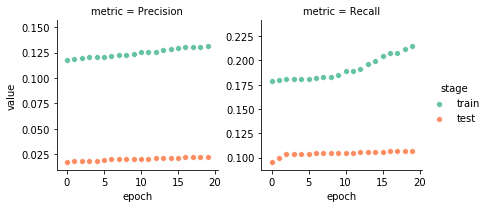

In [188]:
output1, _ = track_model_metrics(model=model1, train_interactions=train_interactions, 
                              test_interactions=test_interactions, k=K,
                              no_epochs=NO_EPOCHS, no_threads=NO_THREADS)

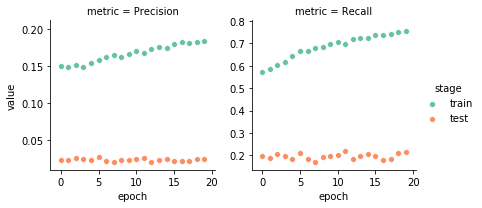

In [189]:
output2, _ = track_model_metrics(model=model2, train_interactions=train_interactions2, 
                              test_interactions=test_interactions2, k=K,
                              no_epochs=NO_EPOCHS, no_threads=NO_THREADS, 
                              item_features=item_features,
                              user_features=user_features)

### Performance comparison

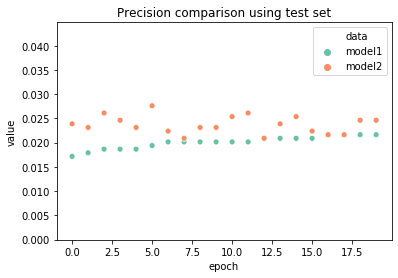

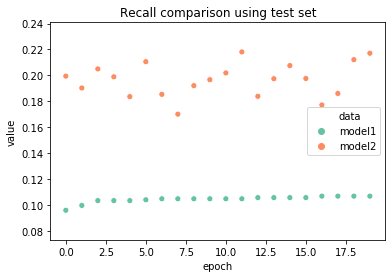

In [190]:
for i in ['Precision', 'Recall']:
    sns.set_palette("Set2")
    plt.figure()
    sns.scatterplot(x="epoch", y="value", hue='data',
                data=compare_metric(df_list = [output1, output2], metric=i)
               ).set_title(f'{i} comparison using test set');

## Similar users and items

### User affinity

In [191]:
_, user_embeddings = model2.get_user_representations(features=user_features)
user_embeddings

array([[-0.14503694,  0.8039905 , -0.4029711 , ...,  0.87174827,
         0.16886434, -0.5000943 ],
       [ 0.11329399,  0.22754326, -0.13982655, ..., -0.03745572,
         0.18275394,  0.539052  ],
       [-0.00763982,  1.0751845 , -0.47231695, ...,  0.7129314 ,
         0.1915096 , -0.324929  ],
       ...,
       [-0.15628797,  0.30277354,  0.0522608 , ..., -0.40000588,
        -0.05106713,  0.3601698 ],
       [-0.11804959,  0.5298451 , -0.24146825, ...,  0.6033182 ,
         0.07923955, -0.35063392],
       [-0.23662624, -0.13744253, -0.2785592 , ..., -0.47962987,
        -0.2053147 ,  0.58984685]], dtype=float32)

In [192]:
similar_users(user_id=1, user_features=user_features, 
            model=model2)

,userID,score
0,8,0.999040
1,6,0.998996
2,7,0.998002
3,5,0.997761
4,3,0.997721
5,13,0.997496
6,62,0.997355
7,77,0.997325
8,16,0.997205
9,106,0.997202


### Item affinity

In [193]:
_, item_embeddings = model2.get_item_representations(features=item_features)
item_embeddings

array([[ 0.5573949 ,  0.9864713 , -0.9100379 , ...,  0.18501464,
         1.2651194 ,  0.00782661],
       [ 0.50913566,  1.423477  , -0.72062254, ...,  0.23080629,
         0.34751377,  0.16211897],
       [-2.3705373 ,  0.87094736, -0.82532907, ...,  0.11863324,
         0.9646424 ,  0.5176085 ],
       ...,
       [ 0.90935814,  0.4357223 , -0.18072581, ...,  0.47129416,
         0.05984697, -0.3635678 ],
       [-0.62071615,  0.25604257, -0.03255743, ..., -0.04901496,
        -0.46484652, -0.3366678 ],
       [-1.1525809 , -0.59018654, -0.4889273 , ..., -0.75842094,
        -0.15463811,  0.3088231 ]], dtype=float32)

In [194]:
similar_items(item_id=10, item_features=item_features, 
            model=model2)

,itemID,score
0,358,0.986575
1,4,0.983740
2,109,0.982707
3,31,0.975392
4,356,0.968527
5,13,0.968337
6,9,0.965902
7,76,0.961415
8,435,0.960107
9,67,0.947977


### Predict


In [195]:
def sample_recommendation(
    user_id,
    data,
    uid_map,
    iid_map,
    interactions,
    model,
    num_threads,
    user_features=None,
    item_features=None,
):
    users, items, preds = [], [], []
    item = list(data.itemID.unique())
    for user in user_id:
        user = [user] * len(item)
        users.extend(user)
        items.extend(item)

    all_predictions = pd.DataFrame(data={"userID": users, "itemID": items})
    all_predictions["uid"] = all_predictions.userID.map(uid_map)
    all_predictions["iid"] = all_predictions.itemID.map(iid_map)

    dok_weights = interactions.todok()
    all_predictions["rating"] = all_predictions.apply(
        lambda x: dok_weights[x.uid, x.iid], axis=1
    )

    all_predictions = all_predictions[all_predictions.rating < 1].reset_index(drop=True)
    all_predictions = all_predictions.drop("rating", axis=1)

    all_predictions["prediction"] = all_predictions.apply(
        lambda x: model.predict(
            user_ids=x["uid"],
            item_ids=[x["iid"]],
            user_features=user_features,
            item_features=item_features,
            num_threads=num_threads,
        )[0],
        axis=1,
    )
    
    all_predictions['prediction'] = all_predictions.apply(lambda x: -x['prediction'],axis=1)
    all_predictions.sort_values(by=['prediction'],inplace=True)
    return all_predictions[["userID", "itemID", "prediction"]]

df = sample_recommendation( ['5ec3ba5374f7660d73aa1201'],data, uid_map, iid_map, 
                       interactions=train_interactions2,
                       user_features=user_features,
                       item_features=item_features,
                       model=model2,
                       num_threads=NO_THREADS)

In [196]:
df = df.merge(pd.read_csv("../../Post dataset/posts.csv"), on='itemID')
df

,userID,itemID,prediction,title,category,post_type
0,5ec3ba5374f7660d73aa1201,5ec7aafbec493f4a26558857,112.490555,FASHION ILLUSTRATION,Fashion Design|Illustration|Watercolours,artwork
1,5ec3ba5374f7660d73aa1201,5ec7ad1aec493f4a26558869,112.499001,FASHION ILLUSTRATION (street fashion),Fashion Design|Illustration|Conceptual|Waterco...,artwork
2,5ec3ba5374f7660d73aa1201,5eb2c11210426255a7aaa052,112.501228,Gangster Style,Drawings,artwork
3,5ec3ba5374f7660d73aa1201,5eb1407c10426255a7aa9fdb,112.551956,PENCIL RENDERING,Drawings,artwork
4,5ec3ba5374f7660d73aa1201,5eca7601ec493f4a26558a62,112.649551,Always do Right 👍🏻,Learning,skill
5,5ec3ba5374f7660d73aa1201,5e9f4421a3258347b42f2e54,112.769989,Handcrafted,Sculptures,artwork
6,5ec3ba5374f7660d73aa1201,5ec2b27974f7660d73aa1115,112.873276,Importance of Design.,Fashion Desigining|Pattern & Culture|Fashion T...,blog
7,5ec3ba5374f7660d73aa1201,5e8cc876a3258347b42f26a3,112.933769,Negative or Positive No. (PHP),NaN,project
8,5ec3ba5374f7660d73aa1201,5eca6ddbec493f4a26558a46,112.935249,Always Remember !!!,Learning,skill
9,5ec3ba5374f7660d73aa1201,5ecd5d417023451e662235c5,112.962540,"Machine Learning”&“Operations"" (MlOps)",Computer Technology|Machine Learning,blog


### Save and Load

In [197]:
import pickle

with open('model2.pickle', 'wb') as fle:
    pickle.dump(model2, fle, protocol=pickle.HIGHEST_PROTOCOL)

In [198]:
model2

In [199]:
model2_copy = open("model2.pickle","rb")
model2_copy = pickle.load(model2_copy)
model2_copy

In [200]:
df = sample_recommendation( ['5ec3ba5374f7660d73aa1201'],data, uid_map, iid_map, 
                       interactions=train_interactions2,
                       user_features=user_features,
                       item_features=item_features,
                       model=model2_copy,
                       num_threads=NO_THREADS)
df.head()

,userID,itemID,prediction
79,5ec3ba5374f7660d73aa1201,5ec7aafbec493f4a26558857,112.490555
31,5ec3ba5374f7660d73aa1201,5ec7ad1aec493f4a26558869,112.499001
5,5ec3ba5374f7660d73aa1201,5eb2c11210426255a7aaa052,112.501228
48,5ec3ba5374f7660d73aa1201,5eb1407c10426255a7aa9fdb,112.551956
26,5ec3ba5374f7660d73aa1201,5eca7601ec493f4a26558a62,112.649551


### Flask

In [211]:
url = 'http://127.0.0.1:5000/'
params ={'user_id': '5ec3ba5374f7660d73aa1201'}
response = requests.get(url, params)
# response.json()
response

<Response [404]>

In [208]:
header = {'Content-Type': 'application/json', \
                  'Accept': 'application/json'}

# df = pd.read_csv('../data/test.csv', encoding="utf-8-sig")
df = pd.DataFrame(['5ec3ba5374f7660d73aa1201'],columns = ['user_id'])
df = df.to_json(orient='records')
df

'[{"user_id":"5ec3ba5374f7660d73aa1201"}]'

In [209]:
import requests
import json
resp = requests.post("http://127.0.0.1:5000/predict",data = json.dumps(df),headers= header)
resp

<Response [500]>